# Goals of this notebook:  
### Where do actual ganglion cells fall on the colormap of info?

In [129]:
import numpy as np
from scipy.stats import sem

# import my functions
# import info_theory_functions as info
from lnl_model_functions import *
from atick_redlich_functions import *
from get_davids_data import *
from image_processing_functions import *
import h5py

# from scipy.optimize import minimize
# from scipy import fft, arange
# from random import randint
# from cmath import polar
# from numpy.fft import fft2
# from numpy.fft import fftshift
# from sklearn.decomposition import PCA
# from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, minimize
from scipy.stats import sem
from scipy.interpolate import interp1d


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
from matplotlib.pyplot import *

# note that nonposx(y) for log plots will no longer work with this package
# I recommend against enabling the whole notebook, since some plots come out funny.
# Instead, just use mpld3.display() at the end of cells you want to interact with.
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import natural images

In [2]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = '/Users/lmcintosh/data/images/Tkacik/cd13A' # flood plain, water, horizon
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)

Only 78 files in directory.


In [3]:
allRot  = [spectrum2d(p,spacing=spacing,frequencyFlag=False) for p in patches]
specRot = np.mean(allRot, axis=0) # average out the amplitude spectrum over all images
frqRot, tmp = spectrum2d(patches[0],spacing=spacing,frequencyFlag=True)
error = [sem([allRot[j][i] for j in range(len(patches))]) for i in range(len(frqRot))]
originalSpectra = specRot
originalErrors  = error
originalFreqs   = frqRot

# Signal

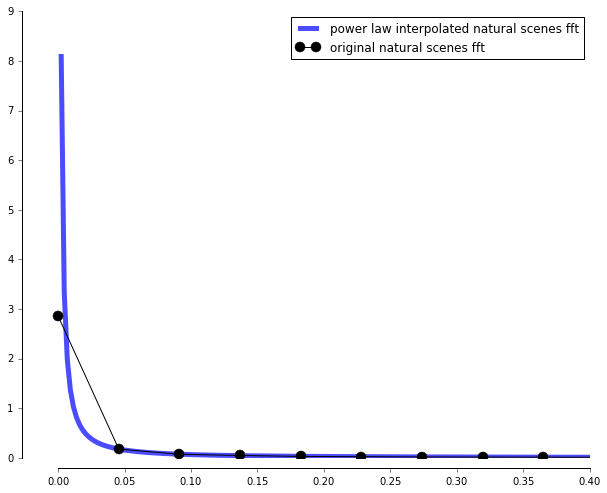

In [4]:
# interpolate signal amplitude
# power law
npoints = 10000
def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers
popt, pcov  = curve_fit(func, originalFreqs[1:], originalSpectra[1:])
more_signal_freq   = np.linspace(0., originalFreqs[-1], npoints)[1:]
more_signal_amp = func(more_signal_freq, *popt)

plt.plot(more_signal_freq, more_signal_amp, 'b', linewidth=5, alpha=0.7, label='power law interpolated natural scenes fft')
plt.plot(originalFreqs, originalSpectra, 'k.-', markersize=20, label='original natural scenes fft')
plt.legend()
plt.xlim([-0.02,0.4])
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

# Define range of input and output noises we're considering  
Here I'm using the same noises used for the figure with multiple SNRs

In [5]:
noises = [(0.05, 0.1), (0.12, 0.35), (0.08, 0.2), (0.2, 0.42)]

## Define information at a given frequency

In [6]:
def info_at_freq(freqs, signal_amplitude, filter_interpolation_function, function_const=1., input_noise=0.12, output_noise=0.35):
    numerator = (signal_amplitude * function_const * filter_interpolation_function(freqs))**2
    denominator = ((input_noise * function_const * filter_interpolation_function(freqs))**2 + output_noise**2)
    return 0.5*np.log2(1.0 + (numerator/denominator))

# Get center width from ganglion cell data

In [7]:
ganglion_rfs = load_ganglion_cells()
interp_ganglions     = get_interp(ganglion_rfs, nPoints = 500, mode='valid')
aligned_ganglion_rfs = np.vstack([y for x,y in interp_ganglions])
valid_space          = interp_ganglions[0][0] - 0.25
mean_ganglion = np.mean(aligned_ganglion_rfs, axis=0)

In [8]:
def diff_of_gaussians(space, center_width, surround_width, center_strength, surround_strength):
    center = gaussian(x=space, sigma=center_width, mu=0)
    surround = gaussian(x=space, sigma=surround_width, mu=0)
    difference = center_strength * center - surround_strength * surround
    return difference

In [9]:
def diff_of_gaussians_fixed_center(space, surround_width, center_strength, surround_strength):
    center = gaussian(x=space, sigma=1.751050, mu=0)
    surround = gaussian(x=space, sigma=surround_width, mu=0)
    difference = center_strength * center - surround_strength * surround
    return difference

In [10]:
popt, pcov = curve_fit(diff_of_gaussians, valid_space, mean_ganglion, p0=[1.7, 7.4, -11, -60])
popt

array([  1.47729653,   8.46181925,  -6.11208239, -25.92723796])

In [11]:
center_width = popt[0]

In [12]:
difference = diff_of_gaussians(valid_space, *popt)

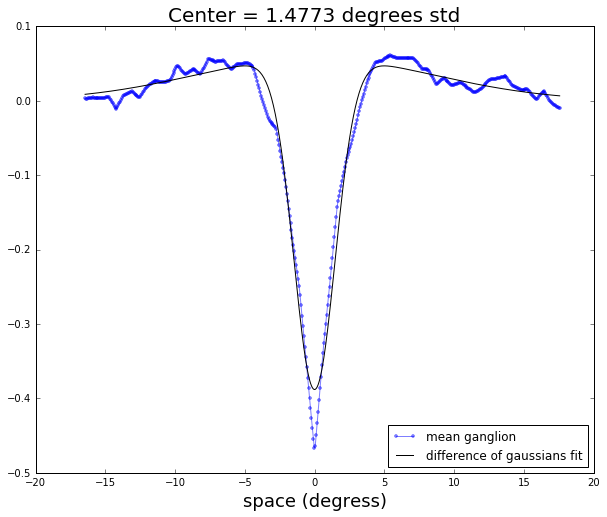

In [13]:
plot(valid_space, mean_ganglion, 'b.-', alpha=0.5, label='mean ganglion')
plot(valid_space, difference, 'k', label='difference of gaussians fit')
plt.legend(loc='lower right')
plt.xlabel('space (degress)', fontsize=18)
plt.title('Center = %0.4f degrees std' %(popt[0]), fontsize=20)

# Define model

In [14]:
def filter_model(horz_weight, ama_weight, center_weight, surround_weight, center_width=1.751050):
    # Get original data
    horz_pfs = get_horizontal_projective_field()
    ama_pfs  = get_amacrine_projective_field()

    # get means of the projective fields
    space_h, horz_pf, horz_sem = get_mean(horz_pfs)
    space_a, ama_pf, ama_sem   = get_mean(ama_pfs)

    # interpolate horz and ama to get a unified space; mode='valid'
    horz_interp = interp1d(space_h, horz_pf, kind='slinear')
    ama_interp  = interp1d(space_a, ama_pf, kind='slinear')
    space       = np.linspace(np.max([np.min(space_h), np.min(space_a)]), np.min([np.max(space_h), np.max(space_a)]), 100)

    # project interpolations on unified space
    horz_pf     = horz_interp(space)
    ama_pf      = ama_interp(space)

    # set sampling rate
    spacing = space[-1] - space[-2]

    # make surround
    surround = horz_weight * horz_pf + ama_weight * ama_pf

    # make center
    center = gaussian(x=space, sigma=center_width, mu=space[abs(surround)==np.max(abs(surround))]) # gaussian

    # put them together
    if len(center.shape) > 1:
        center = center.squeeze()
    rf = center_weight * center + surround_weight * surround

    # Amplitude Spectrum of RF
    rf_f_two_sided = abs(np.fft.fft(rf)) / np.prod(rf.shape)
    n = len(rf_f_two_sided)
    if n % 2 == 0:
        rf_f_one_sided = rf_f_two_sided[:int((n/2) + 1)]
    else:
        rf_f_one_sided = rf_f_two_sided[:int(((n-1)/2) + 1)]
    rf_freqs_one_sided = np.linspace(0, 1./(2*spacing), len(rf_f_one_sided))

    rf_interp = interp1d(rf_freqs_one_sided, rf_f_one_sided, kind='slinear', fill_value=[0.0], bounds_error=False)
    
    return rf_interp

# Fit ganglion cells with model of horizontal, amacrine, bipolar cells

In [61]:
def rf_express(horz_weight, center_weight, center_width=center_width, return_space=False):
    horz_weight = np.min([1.0, abs(horz_weight)])
    ama_weight = 1.0 - horz_weight
    center_weight = np.min([1.0, abs(center_weight)])
    surround_weight = 1.0 - center_weight
    
    # Get original data
    horz_pfs = get_horizontal_projective_field()
    ama_pfs  = get_amacrine_projective_field()

    # get means of the projective fields
    space_h, horz_pf, horz_sem = get_mean(horz_pfs)
    space_a, ama_pf, ama_sem   = get_mean(ama_pfs)

    # interpolate horz and ama to get a unified space; mode='valid'
    horz_interp = interp1d(space_h, horz_pf, kind='slinear')
    ama_interp  = interp1d(space_a, ama_pf, kind='slinear')
    space       = np.linspace(np.max([np.min(space_h), np.min(space_a)]), np.min([np.max(space_h), np.max(space_a)]), 100)

    # project interpolations on unified space
    horz_pf     = horz_interp(space)
    ama_pf      = ama_interp(space)

    # set sampling rate
    spacing = space[-1] - space[-2]

    # make surround
    surround = horz_weight * horz_pf + ama_weight * ama_pf

    # make center
    center = gaussian(x=space, sigma=center_width, mu=space[abs(surround)==np.max(abs(surround))]) # gaussian

    # put them together
    if len(center.shape) > 1:
        center = center.squeeze()
    rf = center_weight * center + surround_weight * surround
    
    if return_space:
        return space, rf
    else:
        return rf

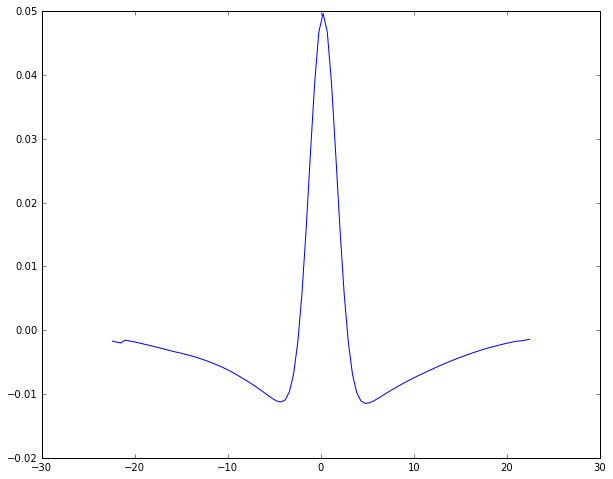

In [65]:
space, rf = rf_express(0.8, 0.9, return_space=True)
plt.plot(space, rf)

In [80]:
def model_error_to_ganglion_cells(weights, valid_space=valid_space, mean_ganglion=mean_ganglion):
    horz_weight, center_weight = weights
    space, rf = rf_express(horz_weight, center_weight, return_space=True)
    model_rf = interp1d(space, -rf, kind='slinear') # negative since we have OFF cells
    normalized_model_rf = np.max(abs(mean_ganglion))*model_rf(valid_space)/np.max(abs(model_rf(valid_space)))
    return sum(abs(normalized_model_rf - (mean_ganglion-np.mean(mean_ganglion))))

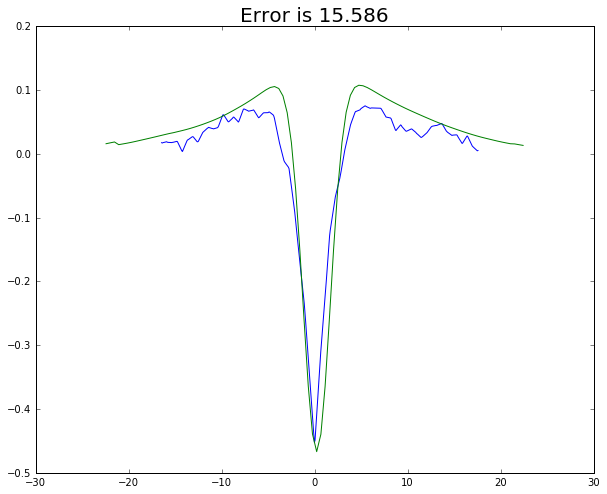

In [81]:
plt.plot(valid_space, mean_ganglion-np.mean(mean_ganglion))
plt.plot(space, -np.max(abs(mean_ganglion))*rf/np.max(abs(rf)))
plt.title('Error is %0.3f' %(model_error_to_ganglion_cells([0.8, 0.9])), fontsize=20)

In [82]:
popt = minimize(model_error_to_ganglion_cells, np.array([0.8,0.9]))

In [83]:
popt

      fun: 8.726766463254867
 hess_inv: array([[  1.60296999e-03,  -2.00765000e-05],
       [ -2.00765000e-05,   2.94775637e-06]])
      jac: array([ 0.        ,  0.81307817])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 496
      nit: 11
     njev: 121
   status: 2
  success: False
        x: array([ 1.00035341,  0.93134262])

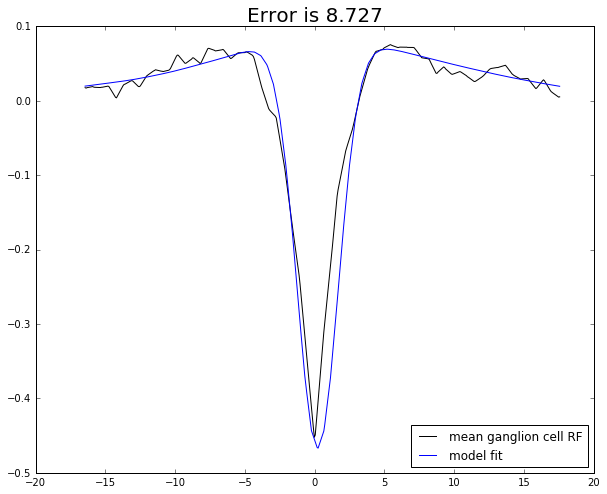

In [87]:
horz_weight, center_weight = popt.x
space, rf = rf_express(horz_weight, center_weight, return_space=True)
model_rf = interp1d(space, -rf, kind='slinear') # negative since we have OFF cells
normalized_model_rf = np.max(abs(mean_ganglion))*model_rf(valid_space)/np.max(abs(model_rf(valid_space)))

plt.plot(valid_space, mean_ganglion-np.mean(mean_ganglion), 'k', label='mean ganglion cell RF')
plt.plot(valid_space, normalized_model_rf, 'b', label='model fit')
plt.title('Error is %0.3f' %(model_error_to_ganglion_cells(popt.x)), fontsize=20)
plt.legend(loc='lower right')

# This fit basically has 100% horizontal cells and 0% amacrine cells. This could be due to larger centers which obfuscate any amacrine cell contribution. So try fitting to narrow ganglions

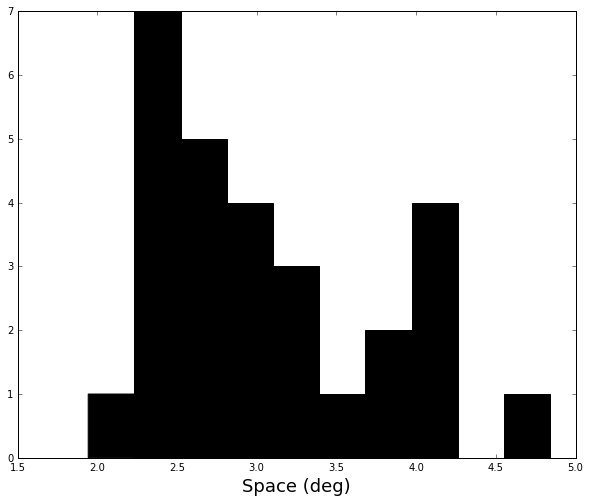

In [108]:
widths = []
spacing = np.mean(np.diff(valid_space))
for rf in aligned_ganglion_rfs:
    pos_inds = np.array([i for i in range(len(rf)) if rf[i]-np.mean(rf) > 0])
    lefties  = len(valid_space)/2 - pos_inds
    left_width  = np.min(lefties[lefties>=0])
    right_width = np.min(-lefties[lefties<0])
    #widths.append(np.min(abs(48 - pos_inds)))
    widths.append(np.mean([spacing*left_width, spacing*right_width]))
counts, bins, _ = hist(widths, color='k')
plt.xlabel('Space (deg)', fontsize=18)

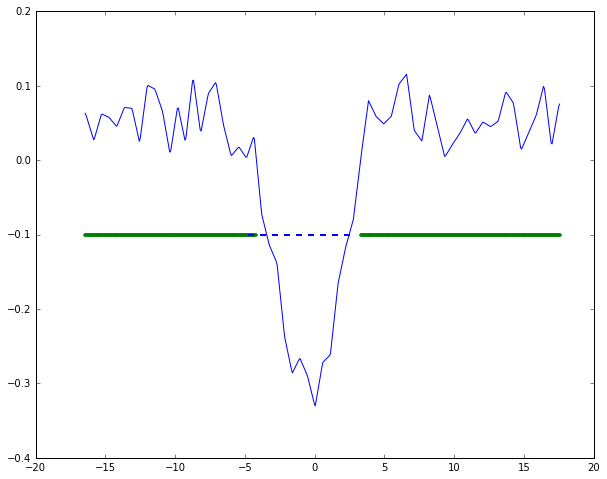

In [119]:
plt.plot(valid_space, rf-np.mean(rf))
plt.plot(valid_space[pos_inds], [-0.1]*len(pos_inds), '.')
plt.plot(np.linspace(-left_width*spacing, right_width*spacing, 10), 10*[-.1], 'b--', linewidth=2)

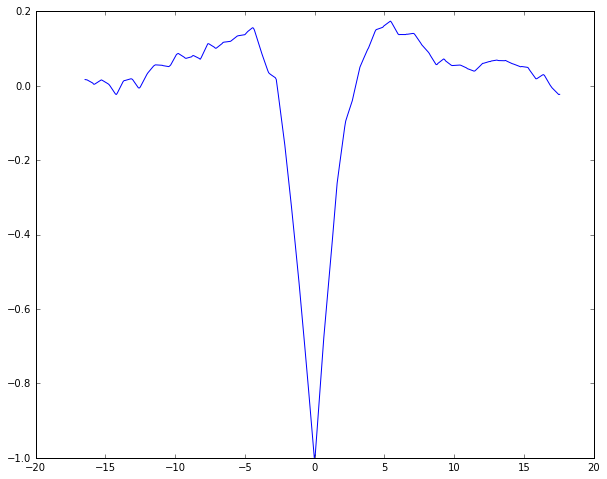

In [121]:
narrow_ganglions = aligned_ganglion_rfs[np.array(widths) < 3.5]
mean_narrow_ganglion = np.mean(narrow_ganglions, axis=0)
plot(valid_space, mean_narrow_ganglion/np.max(abs(mean_narrow_ganglion)))

## Actually, why not just fit each cell individually

In [122]:
fits = []
errors = []
for i,rf in enumerate(aligned_ganglion_rfs):
    def model_error_to_ganglion_cells(weights, valid_space=valid_space, mean_ganglion=rf):
        horz_weight, center_weight = weights
        space, rf = rf_express(horz_weight, center_weight, return_space=True)
        model_rf = interp1d(space, -rf, kind='slinear') # negative since we have OFF cells
        normalized_model_rf = np.max(abs(mean_ganglion))*model_rf(valid_space)/np.max(abs(model_rf(valid_space)))
        return sum(abs(normalized_model_rf - (mean_ganglion-np.mean(mean_ganglion))))
    
    popt = minimize(model_error_to_ganglion_cells, np.array([0.8,0.9]))
    fits.append(popt.x)
    errors.append(popt.fun)
    print('Fit ganglion cell %d/%d.' %(i,len(aligned_ganglion_rfs)))

In [123]:
fits_array = np.stack(fits)
fits_array.shape

(28, 2)

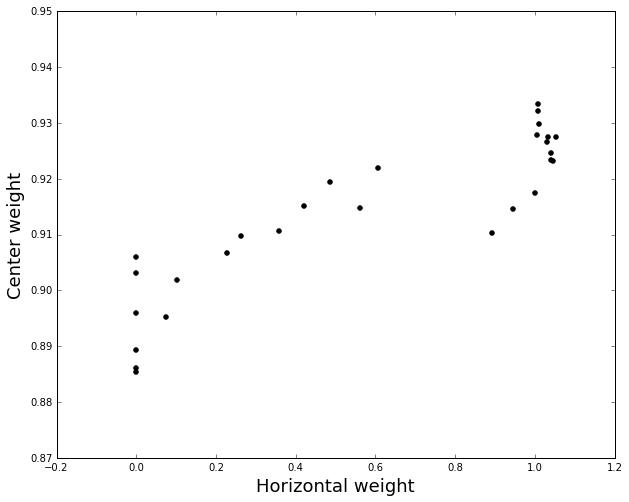

In [127]:
plt.scatter(fits_array[:,0], fits_array[:,1], c='k')
plt.xlabel('Horizontal weight', fontsize=18)
plt.ylabel('Center weight', fontsize=18)

In [137]:
with h5py.File('info_grid_search.h5', 'r') as f:
    info_color_map = np.array(f['info_colormap'])
    center_weights = np.array(f['center_weight_xaxis'])
    horz_weights = np.array(f['horz_weight_yaxis'])

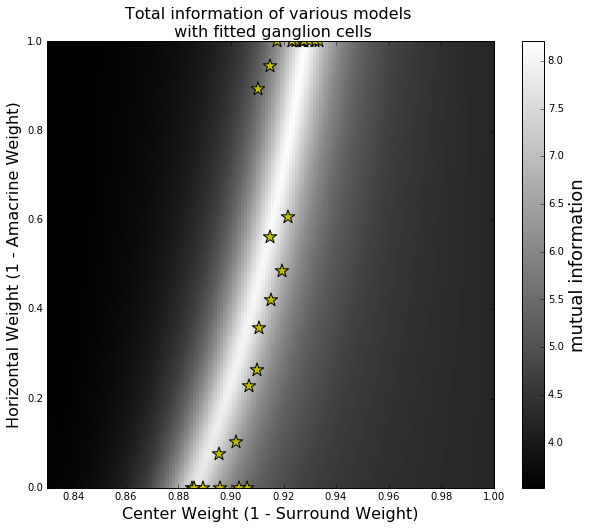

In [171]:
plt.imshow(info_color_map, extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
cbar = plt.colorbar()
cbar.ax.set_ylabel('mutual information', fontsize=18)
plt.scatter(fits_array[:,1], np.where(fits_array[:,0] > 1, 1, fits_array[:,0]), c='y', s=200, marker='*')
# plt.xlim([0,1])
plt.ylim([0,1])
plt.xlim([center_weights[0], center_weights[-1]])
plt.title('Total information of various models \n with fitted ganglion cells', fontsize=16)
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)

## Are errors in fitting correlated with parameters?  
No.

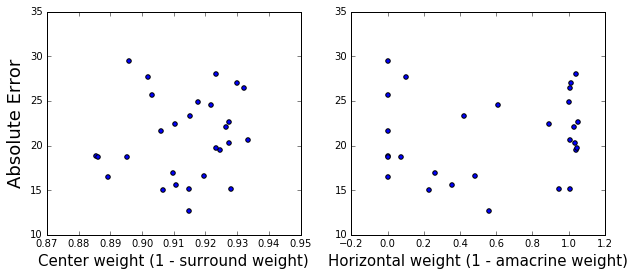

In [179]:
fig = plt.gcf()
fig.set_size_inches((10,4))
plt.subplot(1,2,1)
plt.scatter(fits_array[:,1], errors)
plt.xlabel('Center weight (1 - surround weight)', fontsize=15)
plt.ylabel('Absolute Error', fontsize=18)
plt.subplot(1,2,2)
plt.scatter(fits_array[:,0], errors)
plt.xlabel('Horizontal weight (1 - amacrine weight)', fontsize=15)

## Verify fits with random initializations

In [180]:
fits_randinit = []
errors_randinit = []
for i,rf in enumerate(aligned_ganglion_rfs):
    def model_error_to_ganglion_cells(weights, valid_space=valid_space, mean_ganglion=rf):
        horz_weight, center_weight = weights
        space, rf = rf_express(horz_weight, center_weight, return_space=True)
        model_rf = interp1d(space, -rf, kind='slinear') # negative since we have OFF cells
        normalized_model_rf = np.max(abs(mean_ganglion))*model_rf(valid_space)/np.max(abs(model_rf(valid_space)))
        return sum(abs(normalized_model_rf - (mean_ganglion-np.mean(mean_ganglion))))
    
    popt = minimize(model_error_to_ganglion_cells, np.array([np.random.rand(),np.random.rand()]))
    fits_randinit.append(popt.x)
    errors_randinit.append(popt.fun)
    print('Fit ganglion cell %d/%d.' %(i,len(aligned_ganglion_rfs)))

Fit ganglion cell 0/28.
Fit ganglion cell 1/28.
Fit ganglion cell 2/28.
Fit ganglion cell 3/28.
Fit ganglion cell 4/28.
Fit ganglion cell 5/28.
Fit ganglion cell 6/28.
Fit ganglion cell 7/28.
Fit ganglion cell 8/28.
Fit ganglion cell 9/28.
Fit ganglion cell 10/28.
Fit ganglion cell 11/28.
Fit ganglion cell 12/28.
Fit ganglion cell 13/28.
Fit ganglion cell 14/28.
Fit ganglion cell 15/28.
Fit ganglion cell 16/28.
Fit ganglion cell 17/28.
Fit ganglion cell 18/28.
Fit ganglion cell 19/28.
Fit ganglion cell 20/28.
Fit ganglion cell 21/28.
Fit ganglion cell 22/28.
Fit ganglion cell 23/28.
Fit ganglion cell 24/28.
Fit ganglion cell 25/28.
Fit ganglion cell 26/28.
Fit ganglion cell 27/28.


In [182]:
fits_array_randinit = np.stack(fits_randinit)
fits_array_randinit.shape

(28, 2)

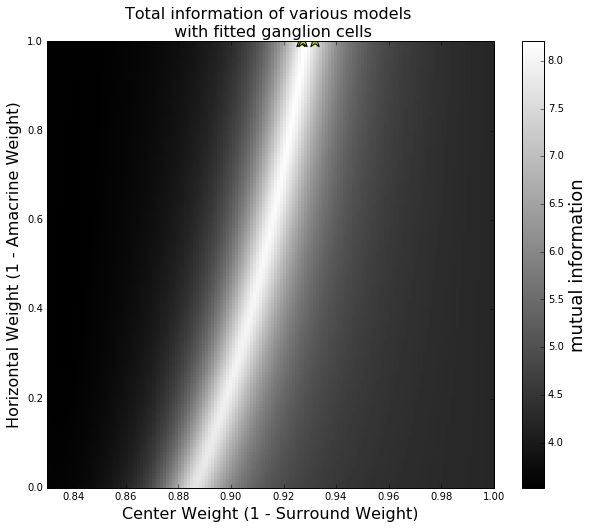

In [183]:
plt.imshow(info_color_map, extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
cbar = plt.colorbar()
cbar.ax.set_ylabel('mutual information', fontsize=18)
plt.scatter(fits_array_randinit[:,1], np.where(fits_array_randinit[:,0] > 1, 1, fits_array_randinit[:,0]), c='y', s=200, marker='*')
# plt.xlim([0,1])
plt.ylim([0,1])
plt.xlim([center_weights[0], center_weights[-1]])
plt.title('Total information of various models \n with fitted ganglion cells', fontsize=16)
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)

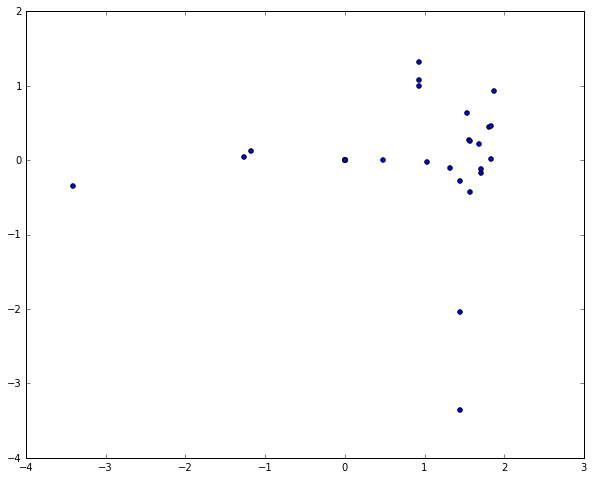

In [192]:
plt.scatter(fits_array_randinit[:,1], fits_array_randinit[:,0])

#### Random initialization doesn't work well

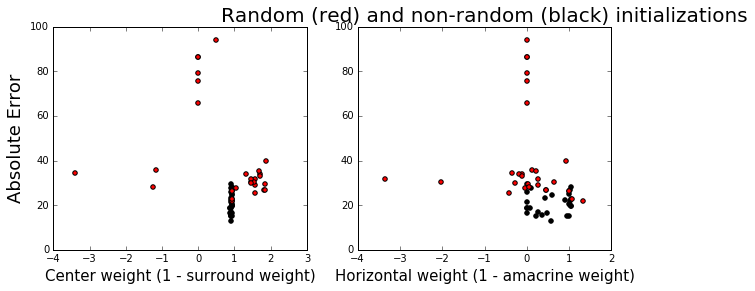

In [200]:
fig = plt.gcf()
fig.set_size_inches((10,4))
plt.subplot(1,2,1)
plt.scatter(fits_array[:,1], errors, c='k')
plt.scatter(fits_array_randinit[:,1], errors_randinit, c='r')
plt.xlabel('Center weight (1 - surround weight)', fontsize=15)
plt.ylabel('Absolute Error', fontsize=18)
plt.subplot(1,2,2)
plt.scatter(fits_array[:,0], errors, c='k')
plt.scatter(fits_array_randinit[:,0], errors_randinit, c='r')
plt.xlabel('Horizontal weight (1 - amacrine weight)', fontsize=15)
plt.title('Random (red) and non-random (black) initializations', fontsize=20)

## Random initialization of horizontal/amacrine cell weight, but not of center weight

In [ ]:
fits_randinit = []
errors_randinit = []
for i,rf in enumerate(aligned_ganglion_rfs):
    def model_error_to_ganglion_cells(weights, valid_space=valid_space, mean_ganglion=rf):
        horz_weight, center_weight = weights
        space, rf = rf_express(horz_weight, center_weight, return_space=True)
        model_rf = interp1d(space, -rf, kind='slinear') # negative since we have OFF cells
        normalized_model_rf = np.max(abs(mean_ganglion))*model_rf(valid_space)/np.max(abs(model_rf(valid_space)))
        return sum(abs(normalized_model_rf - (mean_ganglion-np.mean(mean_ganglion))))
    
    popt = minimize(model_error_to_ganglion_cells, np.array([np.random.rand(), 0.91])) # choose 0.91 b/c in middle
    fits_randinit.append(popt.x)
    errors_randinit.append(popt.fun)
    print('Fit ganglion cell %d/%d.' %(i,len(aligned_ganglion_rfs)))

Fit ganglion cell 0/28.
Fit ganglion cell 1/28.
Fit ganglion cell 2/28.

In [ ]:
fits_array_randinit = np.stack(fits_randinit)
fits_array_randinit.shape

In [ ]:
plt.imshow(info_color_map, extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
cbar = plt.colorbar()
cbar.ax.set_ylabel('mutual information', fontsize=18)
plt.scatter(fits_array_randinit[:,1], np.where(fits_array_randinit[:,0] > 1, 1, fits_array_randinit[:,0]), c='y', s=200, marker='*')
# plt.xlim([0,1])
plt.ylim([0,1])
plt.xlim([center_weights[0], center_weights[-1]])
plt.title('Total information of various models \n with fitted ganglion cells', fontsize=16)
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)

In [ ]:
fig = plt.gcf()
fig.set_size_inches((10,4))
plt.subplot(1,2,1)
plt.scatter(fits_array[:,1], errors, c='k')
plt.scatter(fits_array_randinit[:,1], errors_randinit, c='r')
plt.xlabel('Center weight (1 - surround weight)', fontsize=15)
plt.ylabel('Absolute Error', fontsize=18)
plt.subplot(1,2,2)
plt.scatter(fits_array[:,0], errors, c='k')
plt.scatter(fits_array_randinit[:,0], errors_randinit, c='r')
plt.xlabel('Horizontal weight (1 - amacrine weight)', fontsize=15)
plt.title('Random (red) and non-random (black) initializations', fontsize=20)